In [21]:
!apt install libportaudio2
%pip install sounddevice


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [22]:
from IPython.display import Audio
import IPython
import sounddevice as sd
import soundfile as sf
from scipy import fftpack
import librosa
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

###1. Sygnał audio

Rozdzielczość bitowa: float32
Częstotliwość próbkowania: 48000
Czas trwania: 2.6026666666666665
Liczba kanałów: 1


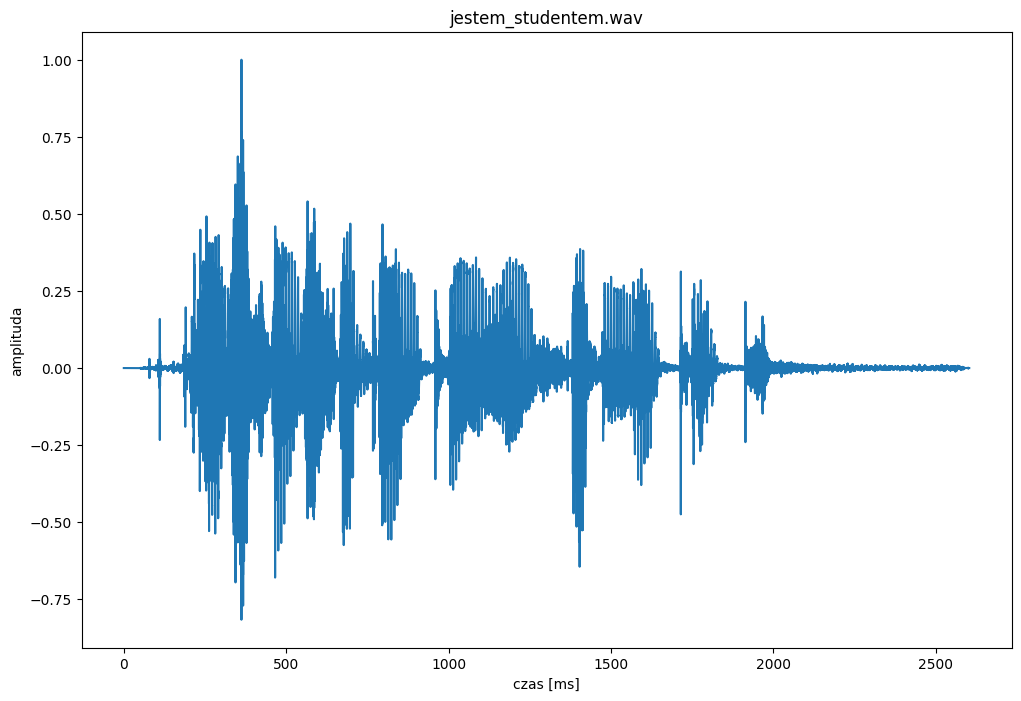

In [23]:
file = 'jestem_studentem.wav'

s, fs = sf.read(file, dtype='float32')
#sd.play(s, fs)
#status = sd.wait()
s = s / np.max(s)
Tc = len(s)/fs #czas trwania
liczba_kanalow = s.ndim #liczba kanałów
print("Rozdzielczość bitowa:", s.dtype) #rozdzielczosc bitowa
print("Częstotliwość próbkowania:", fs) #czestotliwosc probkowania
print("Czas trwania:", Tc) #czas trwania
print("Liczba kanałów:", liczba_kanalow) #liczba kanałów
N = int(np.ceil(Tc*fs))
t = []
for i in range(N):
    t.append(i/fs*1000)
plt.figure(figsize=(12, 8))
plt.plot(t, s)
plt.title(f"{file}")
plt.xlabel('czas [ms]')
plt.ylabel('amplituda')
plt.show()

###2. Wykorzystanie okien kroczących

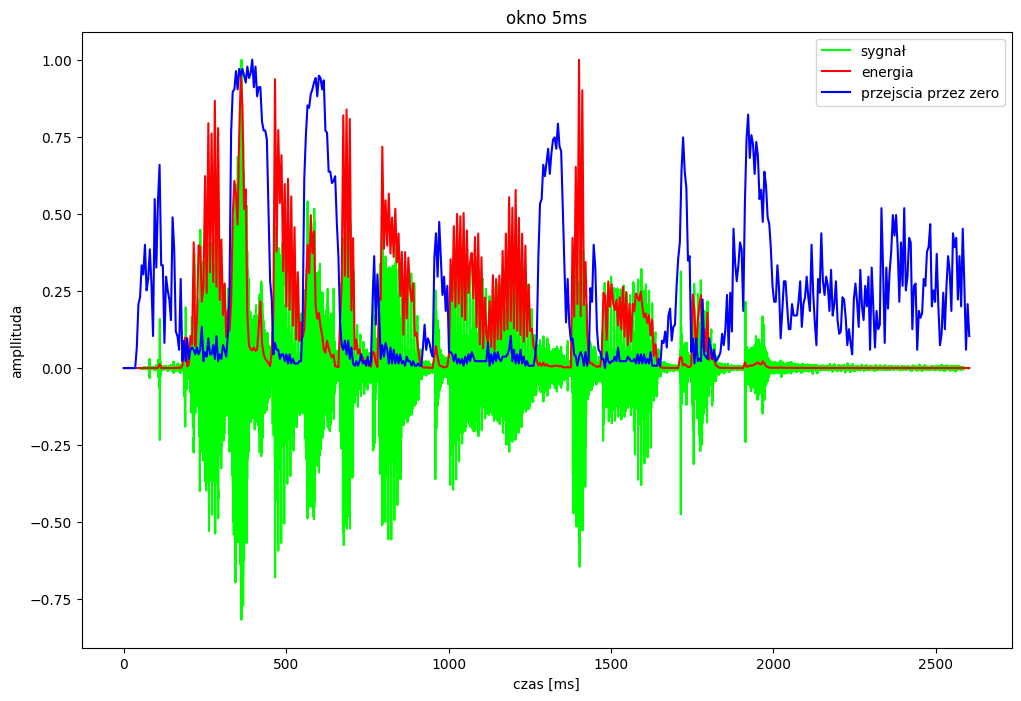

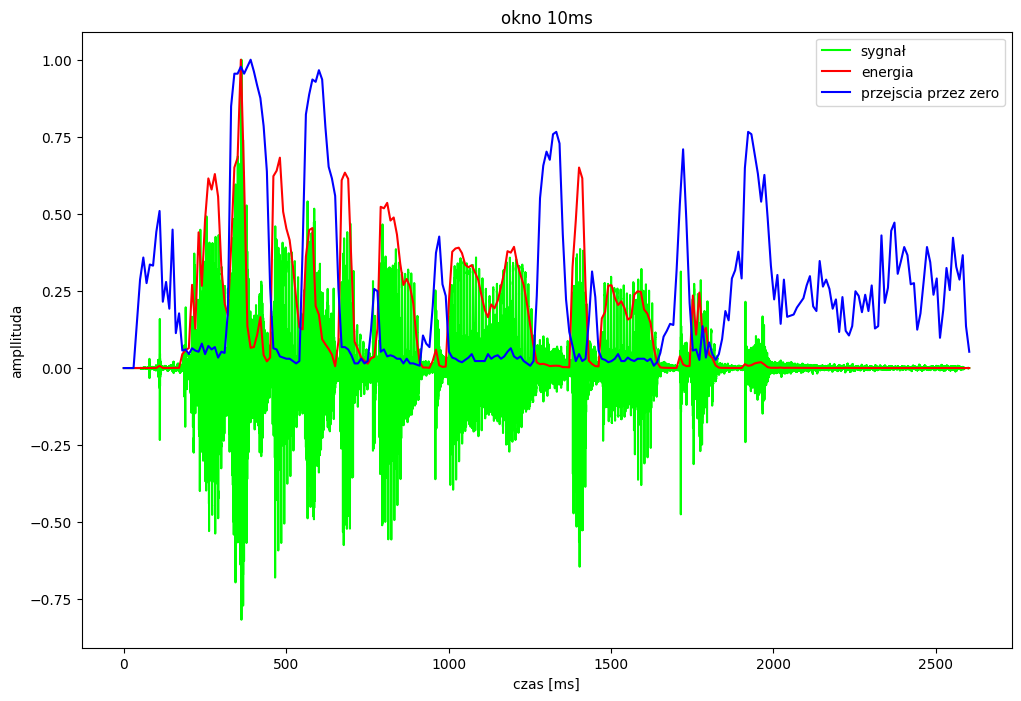

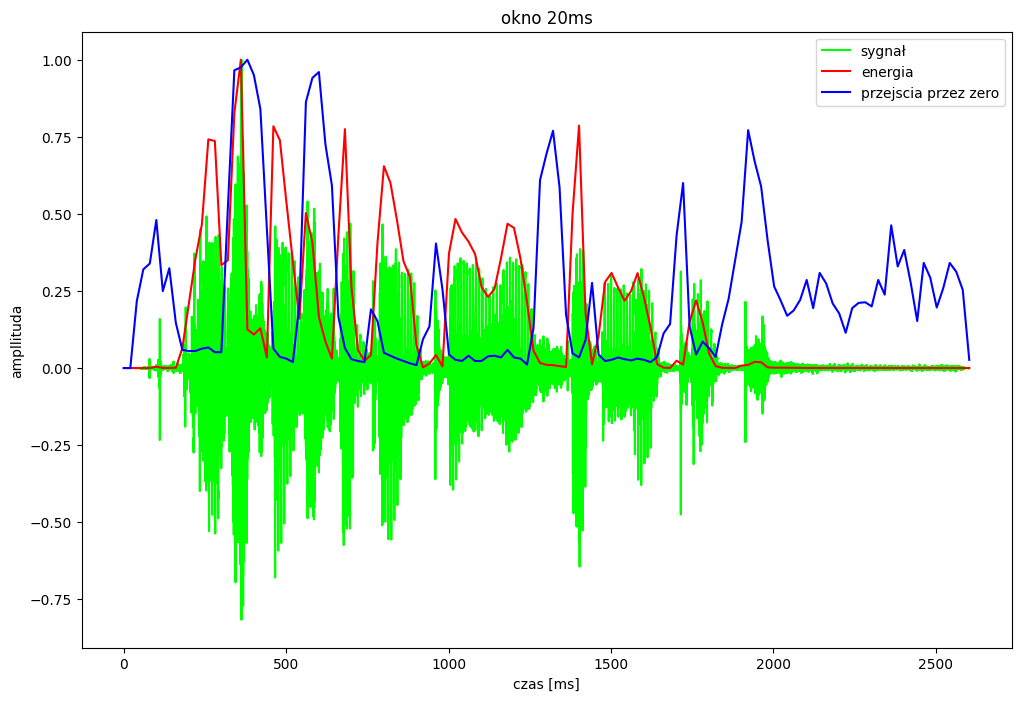

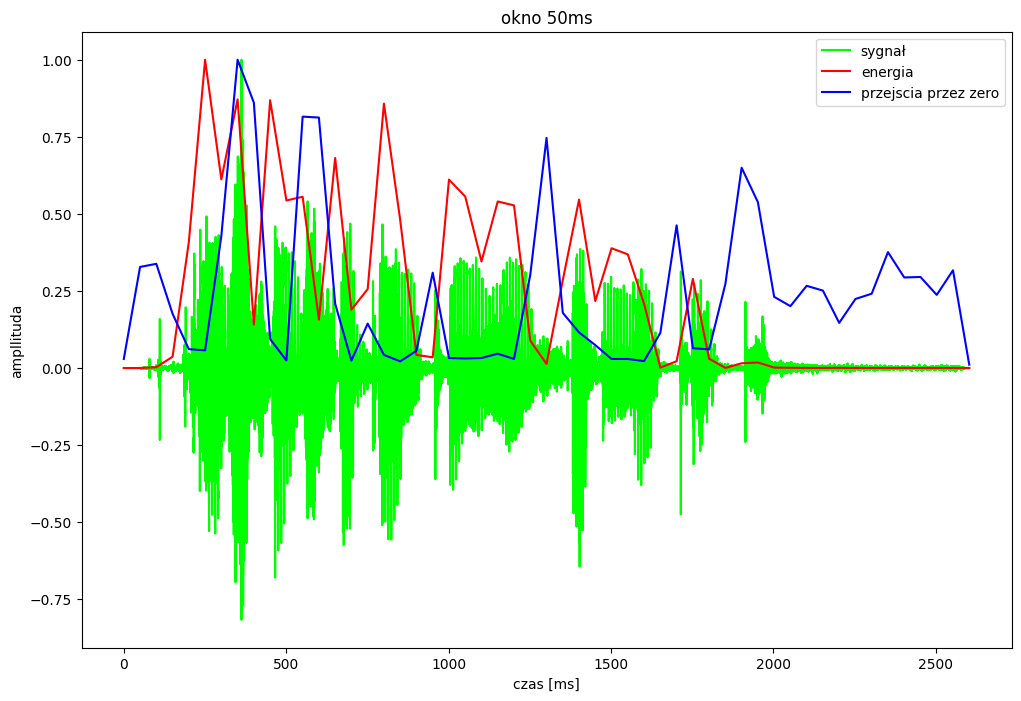

In [24]:
def generuj_ramki(s, dlugosc_ramki=10):
    ramki = []
    dr = int(np.ceil(dlugosc_ramki * fs / 1000)) #długość ramki(liczba próbek)
    for i in range(0, len(s), dr):
        ramki.append([s[i:i + dr]])
    return ramki

def E(ramka): #funkcja energii
    return np.sum(ramka**2)

def Z(ramka): #funkcja przejść przez zero
    sum = 0
    for i in range(len(ramka)-1):
        if (ramka[i]*ramka[i+1]) < 0:
            sum += 1
    return sum

def rysuj_ramki(ramki, dlugosc_ramki=10):
    Ej = []
    Zj = []
    for r in ramki:
        Ej.append(E(r[0]))
        Zj.append(Z(r[0]))
    Ej = Ej / np.max(Ej)
    Zj = Zj / np.max(Zj)
    tframe = np.linspace(0, np.max(t), len(Ej))
    plt.figure(figsize=(12, 8))
    plt.title(f"okno {dlugosc_ramki}ms")
    plt.plot(t, s, 'lime', label='sygnał')
    plt.plot(tframe, Ej, 'r', label='energia')
    plt.plot(tframe, Zj, 'b', label='przejscia przez zero')
    plt.xlabel('czas [ms]')
    plt.ylabel('ampllituda')
    plt.legend()
    plt.show()
ramki = generuj_ramki(s, 10)
ramki5 = generuj_ramki(s, 5)
ramki20 = generuj_ramki(s, 20)
ramki50 = generuj_ramki(s, 50)

rysuj_ramki(ramki5, 5)
rysuj_ramki(ramki, 10)
rysuj_ramki(ramki20, 20)
rysuj_ramki(ramki50, 50)

####**zadanie 3.**
Maksima funkcji energii wskazują kiedy sygnał ma największa amplitudę energii, często odpowiadają dźwięcznym częściom sygnału, natomiast minima mogą wskazywać na ciszę lub bezdźwięczne częsci sygnału.

Maksima funkcji przejść przez zero mogą wskazywać segmenty bezdźwięczne, natomiast minima segmenty dźwięczne.

Wysoka energia i mała liczba przejść przez zero może wskazywać na wystąpienie samogłoski.

Niska energia i duża liczba przejśc przez zero może wskazywac na wystąpienie spółgłoski bezdźwięcznej.

###**zadanie 4.**

Im krótsza ramka, tym bardziej precyzyjne wykrywanie zmian.


###3. Analiza częstotliwości

Częstotliwość podstawowa: 93.75


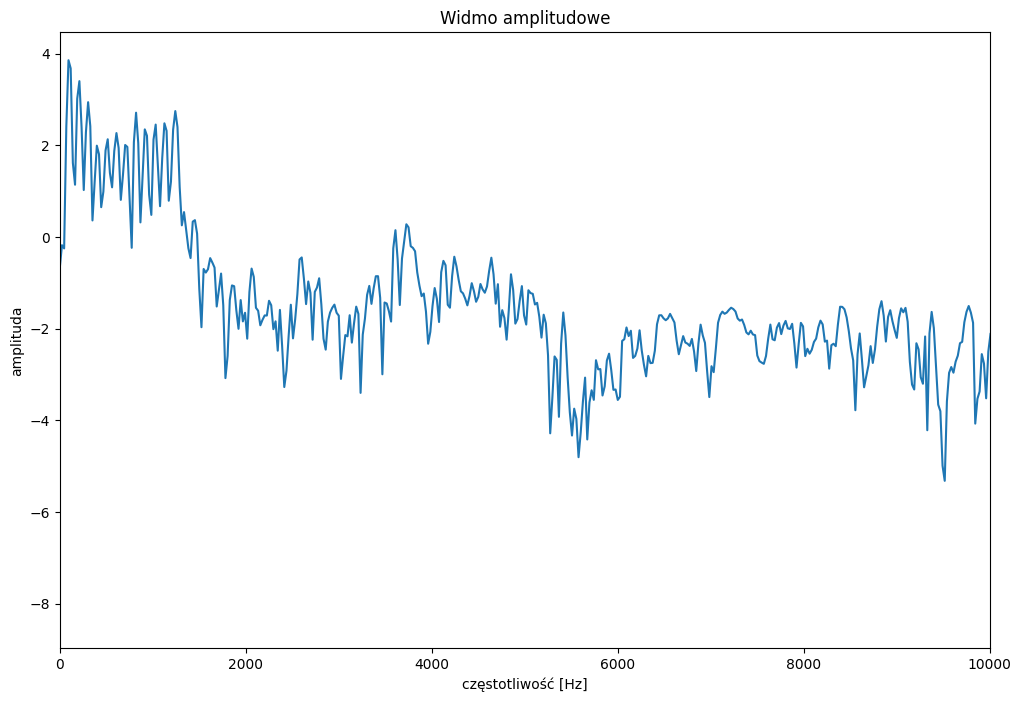

In [25]:
samogloska = s[76800:78848] #samogłoska 'a'
samogloska_h = samogloska*np.hamming(2048) #maskowanie
yf = fftpack.fft(samogloska_h)
widmo = np.log(np.abs(yf))
freq = []

for i in range(len(widmo)): #generowanie jednostki czestotliwosci
    freq.append(i*fs/len(widmo))

F0 = freq[np.argmax(widmo)] #częstotliwość podstawowa
print("Częstotliwość podstawowa:", F0)

plt.figure(figsize=(12, 8))
plt.plot(freq, widmo)
plt.title("Widmo amplitudowe")
plt.xlabel("częstotliwość [Hz]")
plt.ylabel("amplituda")
plt.xlim(0, 10000) #ograniczenie 0-10000 Hz
plt.show()

###4. Rozpozawanie samogłosek ustnych

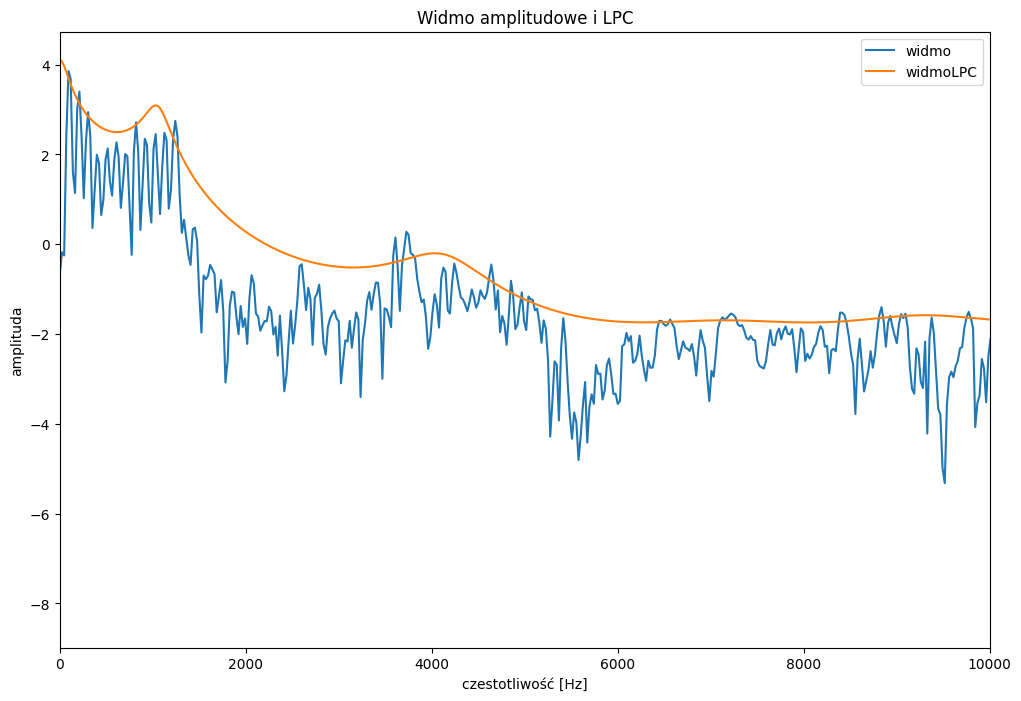

In [27]:
okno = samogloska
p=20
a = librosa.lpc(okno, order=p)
a = np.hstack([a, np.zeros(2048-a.size)]) #łączenie poziome wektorów
yf = fftpack.fft(a)
widmolpc = np.log(np.abs(yf))*(-1)
freq = []
for i in range(len(a)):
    freq.append(i*fs/len(a))

plt.figure(figsize=(12, 8))
plt.plot(freq, widmo, label='widmo')
plt.plot(freq, widmolpc-2.5, label='widmoLPC') #przesunięcie wysokości
plt.title('Widmo amplitudowe i LPC')
plt.xlabel('czestotliwość [Hz]')
plt.ylabel('amplituda')
plt.legend()
plt.xlim(0, 10000)
plt.show()

####**zadanie 3.**
LPC - próbka sygnału może być przedstawiona jako liniowa komibnacja poprzednich próbek.
Wykorzystywana jest w analizie mowy.